# NOTEBOOK (3 of 4) - PyR (Chris Engstrom)

## Q3. Does Q1 complaint type have a useful relationship with any of the building characteristics?

## Contents
1. Business Understanding
2. Analytical Approach
3. Data Requirements
4. Data Collection
5. Data Preparation
6. Exploratory Data Analysis (EDA)
7. Concluding Remarks

## 1. Business Understanding

Problem Statement - The people of New York use the 311 system to report complaints about the non-emergency problems to local authorities. Various agencies in New York are assigned these problems. The Department of Housing Preservation and Development (DHPD) of New York City is the agency that processes 311 complaints that are related to housing and buildings. In the last few years, the number of 311 complaints coming to the DHPD has increased significantly. Although these complaints are not necessarily urgent, the large volume of complaints and the sudden increase is impacting the overall efficiency of operations of the agency.

The DHPD has approached your organization to help them manage the large volume of 311 complaints they are receiving every year. The agency needs answers to several questions which need to be supported by data and analytics:

    1) Which type of complaint should the DHPD of New York City focus on first?
    2) Should DHPD focus on complaints at particular locations where they are most severe?
    3) Does Complaint Type identified in Q1 have a useful relationship with any particular characteristic(s) of the houses/buildings?
    4) Can a predictive model be built to predict the possibility of future Q1 complaints?
    
Your organization has assigned you as the lead data scientist to provide the answers to these questions. You need to work on getting answers to them in this Capstone Project by following the standard approach of data science and machine learning.

## 2. Analytical Approach

1. Load required datasets (NYC311, PLUTO-Bronx)
2. Create NYC311 COMPLAINT dummies
3. Group NYC311 df (at address level) and summarize dummies
4. Join NYC311 and PLUTO dataframes (at address level) to produce a single analytical file
5. Derive mutiple TARGET variable options
6. Derive required features (e.g., incorporating NumFloors, Age of Bldg)
7. Explore relationships between TARGETS and key features
8. Summarize analysis

In [1]:
# Environment Setup
import types
import pandas as pd
import numpy as np
import scipy
import seaborn as sns

from sklearn import preprocessing
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from botocore.client import Config
import ibm_boto3
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_c1d08c5c14374903951f00633e391147 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='************',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

In [2]:
# Create credential and bucket variables
# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_cred = ibm_boto3.client(service_name='s3',
ibm_api_key_id='**************',
ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
config=Config(signature_version='oauth'),
endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

bucket = '*************'

## 3. Data Requirements

Include the following data sources:
1. NYC 311
2. PLUTO (Bronx)

## 4. Data Collection

#### Load NYC311 and PLUTO (Bronx) datasets from IBM Cloud Object Store.

In [3]:
# Load NYC311 file from IBM Cloud Object Store
client_cred.download_file(Bucket=bucket,Key='df_nyc311_raw_cos.pkl',Filename='./df_nyc311_raw_local.pkl')

# Create Pandas dataframe
df_nyc311 = pd.read_pickle('./df_nyc311_raw_local.pkl')

In [4]:
# Load PLUTO (Bronx) data from the IBM Cloud Object Store.
body = client_c1d08c5c14374903951f00633e391147.get_object(Bucket='edx1-donotdelete-pr-5a2mc3zzkipsze',Key='BX_18v1.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_pluto_bx = pd.read_csv(body)
#df_pluto_bx.head()
#df_pluto_bx.info()

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,20,22,23,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 5. Data Preparation

#### 5a. Restrict dataset by date (per Q1 requirements).

In [5]:
# Per Q1 instructions only include NYC311 records before Jan 1, 2019.
df_nyc311_dec312018=df_nyc311[df_nyc311['created_date']<'2019']

# Check 'created_date' field dates for restricted dataset.
#df_nyc311_dec312018[['created_date']].describe()
#df_nyc311_dec312018.info()

#### 5b.Create new NYC311 df that only includes necessary fields and BRONX complaints within targeted ZIPS.

In [6]:
# Create new df from NYC311 df that only includes needed fields.
df_train_nyc = df_nyc311_dec312018[['unique_key','complaint_type','incident_zip','incident_address','street_name','borough']]

# Include NYC311 BRONX records only.
df_train_nyc_bx = df_train_nyc.loc[(df_train_nyc['borough']=='BRONX')]
              
# Include NYC311 BRONX records only with the following ZIPCODES (10468, 10458, 10453, 10457, 10452, 10456, 10451).
bx_zips = [10468.0, 10458.0, 10453.0, 10457.0, 10452.0, 10456.0, 10451.0]
df_train_nyc_bx_zp = df_train_nyc_bx[df_train_nyc_bx['incident_zip'].isin(bx_zips)] 

#df_train_nyc_bx_zp['incident_zip'].value_counts()
#df_train_nyc_bx_zp.head()
#df_train_nyc_bx_zp.info()

#### 5c. Create new PLUTO (BRONX) df that only includes necessary fields.

In [7]:
# Create new df from PLUTO (Bronx) df that only indludes needed fields.
df_train_pluto_bx = df_pluto_bx[['Address','BldgArea','BldgDepth','BuiltFAR','FacilFAR','Lot','LotArea','LotDepth','NumBldgs',
        'NumFloors','ResArea','ResidFAR','YearBuilt','YearAlter1','YearAlter2']]

#df_train_pluto_bx.describe()
#df_train_pluto_bx.info() # 89,854

#### 5d. DROP key PLUTO rows where fields contain ZEROS.

In [8]:
# DROP key PLUTO rows where fields contain ZEROS.
drop_zero7 = df_train_pluto_bx[df_train_pluto_bx['LotDepth'] == 0 ].index
df_train_pluto_bx.drop(drop_zero7, inplace=True)  

drop_zero6 = df_train_pluto_bx[df_train_pluto_bx['LotArea'] == 0 ].index
df_train_pluto_bx.drop(drop_zero6, inplace=True)   

drop_zero5 = df_train_pluto_bx[df_train_pluto_bx['FacilFAR'] == 0 ].index
df_train_pluto_bx.drop(drop_zero5, inplace=True)   

drop_zero12 = df_train_pluto_bx[df_train_pluto_bx['ResidFAR'] == 0 ].index
df_train_pluto_bx.drop(drop_zero12, inplace=True)   

drop_zero8 = df_train_pluto_bx[df_train_pluto_bx['NumBldgs'] == 0 ].index
df_train_pluto_bx.drop(drop_zero8, inplace=True)   

drop_zero1 = df_train_pluto_bx[df_train_pluto_bx['BldgArea'] == 0 ].index
df_train_pluto_bx.drop(drop_zero1, inplace=True)       

drop_zero3 = df_train_pluto_bx[df_train_pluto_bx['BuiltFAR'] == 0 ].index
df_train_pluto_bx.drop(drop_zero3, inplace=True)  

drop_zero9 = df_train_pluto_bx[df_train_pluto_bx['NumFloors'] == 0 ].index
df_train_pluto_bx.drop(drop_zero9, inplace=True)  

drop_zero2 = df_train_pluto_bx[df_train_pluto_bx['BldgDepth'] == 0 ].index
df_train_pluto_bx.drop(drop_zero2, inplace=True)   

#df_train_pluto_bx.describe()
#df_train_pluto_bx.info()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### 5e. DERIVE NYC311 Complaint Dummies.

In [9]:
#Use "One-hot Coding" to create new df with dummies for 'complaint_type'
df_train_nyc_bx_zp_dum = pd.get_dummies(df_train_nyc_bx_zp, prefix='', columns=['complaint_type'])

#df_train_nyc_bx_zp_dum.head()
#f_train_nyc_bx_zp_dum.info()

#### 5f. Group Complaints at ADDRESS level and sum DUMMIES. View df.

In [10]:
#GROUP and SUM DUMMIES (address level)
df_train_nyc_bx_zp_dum_add = df_train_nyc_bx_zp_dum.groupby('incident_address')['incident_address','_CONSTRUCTION','_GENERAL CONSTRUCTION','_HEAT/HOT WATER',
                                        '_HEATING','_PAINT - PLASTER','_PAINT/PLASTER','_PLUMBING','_UNSANITARY CONDITION','_Unsanitary Condition',
                                        '_WATER LEAK','_APPLIANCE','_DOOR/WINDOW','_ELECTRIC','_ELEVATOR','_FLOORING/STAIRS','_GENERAL',
                                        '_NONCONST','_OUTSIDE BUILDING','_SAFETY'].sum()

#df_train_nyc_bx_zp_dum_add.head()
#df_train_nyc_bx_zp_dum_add.info()

#### 5g. DERIVE TOTAL COMPAINTS field and TARGET variable candidates.

In [11]:
# Derive '_Tot_Complaints' feature by adding all complaint dummies.
#df_train_nyc_bx_gc_dum_add['_Tot_Complaints'] = df_train_nyc_bx_gc_dum_add['_GENERAL CONSTRUCTION'] + df_train_nyc_bx_gc_dum_add['_CONSTRUCTION'] + df_train_nyc_bx_gc_dum_add['_HEAT/HOT WATER'] + df_train_nyc_bx_gc_dum_add['_HEATING'] + df_train_nyc_bx_gc_dum_add['_PAINT - PLASTER'] + df_train_nyc_bx_gc_dum_add['_PAINT/PLASTER'] + df_train_nyc_bx_gc_dum_add['_PLUMBING'] + df_train_nyc_bx_gc_dum_add['_UNSANITARY CONDITION'] + df_train_nyc_bx_gc_dum_add['_Unsanitary Condition'] + df_train_nyc_bx_gc_dum_add['_WATER LEAK'] + df_train_nyc_bx_gc_dum_add['_APPLIANCE'] + df_train_nyc_bx_gc_dum_add['_DOOR/WINDOW'] + df_train_nyc_bx_gc_dum_add['_ELECTRIC'] + df_train_nyc_bx_gc_dum_add['_ELEVATOR'] + df_train_nyc_bx_gc_dum_add['_FLOORING/STAIRS'] + df_train_nyc_bx_gc_dum_add['_GENERAL'] + df_train_nyc_bx_gc_dum_add['_NONCONST'] + df_train_nyc_bx_gc_dum_add['_OUTSIDE BUILDING'] + df_train_nyc_bx_gc_dum_add['_SAFETY']
df_train_nyc_bx_zp_dum_add['_Tot_Complaints'] = df_train_nyc_bx_zp_dum_add['_GENERAL CONSTRUCTION'] + df_train_nyc_bx_zp_dum_add['_CONSTRUCTION'] + df_train_nyc_bx_zp_dum_add['_HEAT/HOT WATER'] + df_train_nyc_bx_zp_dum_add['_HEATING'] + df_train_nyc_bx_zp_dum_add['_PAINT - PLASTER'] + df_train_nyc_bx_zp_dum_add['_PAINT/PLASTER'] + df_train_nyc_bx_zp_dum_add['_PLUMBING'] + df_train_nyc_bx_zp_dum_add['_UNSANITARY CONDITION'] + df_train_nyc_bx_zp_dum_add['_Unsanitary Condition'] + df_train_nyc_bx_zp_dum_add['_WATER LEAK'] + df_train_nyc_bx_zp_dum_add['_APPLIANCE'] + df_train_nyc_bx_zp_dum_add['_DOOR/WINDOW'] + df_train_nyc_bx_zp_dum_add['_ELECTRIC'] + df_train_nyc_bx_zp_dum_add['_ELEVATOR'] + df_train_nyc_bx_zp_dum_add['_FLOORING/STAIRS'] + df_train_nyc_bx_zp_dum_add['_GENERAL'] + df_train_nyc_bx_zp_dum_add['_NONCONST'] + df_train_nyc_bx_zp_dum_add['_OUTSIDE BUILDING'] + df_train_nyc_bx_zp_dum_add['_SAFETY']

# Derive primary TARGET variable by adding 'HEAT/HOT WATER' and 'HEATING' dummies.
#df_train_nyc_bx_gc_dum_add['TARGET'] = df_train_nyc_bx_gc_dum_add['_HEAT/HOT WATER'] + df_train_nyc_bx_gc_dum_add['_HEATING']
df_train_nyc_bx_zp_dum_add['TARGET'] = df_train_nyc_bx_zp_dum_add['_HEAT/HOT WATER'] + df_train_nyc_bx_zp_dum_add['_HEATING']

# Derive another potential TARGET_R (Ratio) variable by dividing TOP COMPLAINTS variable by '_Tot_Complaints' variable.
#df_train_nyc_bx_gc_dum_add['TARGET_R'] = df_train_nyc_bx_gc_dum_add['TARGET'] / df_train_nyc_bx_gc_dum_add['_Tot_Complaints']
df_train_nyc_bx_zp_dum_add['TARGET_R'] = df_train_nyc_bx_zp_dum_add['TARGET'] / df_train_nyc_bx_zp_dum_add['_Tot_Complaints']

# Reset Index and RENAME Address field.
df_train_nyc_bx_zp_dum_add = df_train_nyc_bx_zp_dum_add.reset_index()
df_train_nyc_bx_zp_dum_add = df_train_nyc_bx_zp_dum_add.rename(columns={"incident_address": "Address"})

#df_train_nyc_bx_zp_dum_add.head()
#df_train_nyc_bx_zp_dum_add.info()

#### 5h. Create new NYC311 df that only includes key fields.

In [12]:
# Create new NYC311 df that only includes key fields.
df_training_1 = df_train_nyc_bx_zp_dum_add[['Address','TARGET','TARGET_R','_Tot_Complaints']]

#df_training_1.head()
#df_training_1.info()

#### 5i. Join datasets (NYC311 and PLUTO BRONX). View joined df.

In [13]:
# Join datasets (NYC311 and PLUTO BRONX)
df_train_FINAL = df_training_1.merge(df_train_pluto_bx, on='Address', how='inner')

#df_train_FINAL.describe()
#df_train_FINAL.info()
df_train_FINAL.head()

,Address,TARGET,TARGET_R,_Tot_Complaints,BldgArea,BldgDepth,BuiltFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,ResArea,ResidFAR,YearBuilt,YearAlter1,YearAlter2
0,1 DOROTHEA PLACE,1.0,1.000000,1.0,2395,31.0,0.35,2.0,85,6813,125.0,2,2.5,2395,0.90,1920,0,0
1,1 EAST 198 STREET,41.0,0.234286,175.0,58962,101.0,4.37,6.5,29,13500,111.0,1,6.0,56462,6.02,1941,0,0
2,1 WEST TREMONT AVENUE,1.0,1.000000,1.0,31460,120.0,1.51,6.5,1,20800,120.0,2,2.0,0,6.02,1925,0,0
3,10 EAST 198 STREET,102.0,0.515152,198.0,70800,96.0,5.83,6.5,114,12150,106.0,1,6.0,69000,6.02,1941,0,0
4,10 WEST 182 STREET,116.0,0.382838,303.0,47000,87.0,4.70,4.0,61,10000,100.0,1,5.0,47000,4.00,1927,0,0


#### 5j. DERIVE additional TARGET candidate variable that incorporates the PLUTO feature 'NumFloors'.

In [14]:
# Derive another TARGET_F (Ratio) variable by dividing 'TARGET' by 'NumFloors' variable.
df_train_FINAL['TARGET_F'] = df_train_FINAL['TARGET']/df_train_FINAL['NumFloors']

#df_train_FINAL.head()
#df_train_FINAL.info()

#### 5k. DERIVE additional FEATURES that incorporate the PLUTO feature 'NumFloors'.

In [15]:
# Derive new FEATURES by dividing features by 'NumFloors' variable.
df_train_FINAL['R_Lot'] = df_train_FINAL['Lot']/df_train_FINAL['NumFloors']
df_train_FINAL['R_LotArea'] = df_train_FINAL['LotArea']/df_train_FINAL['NumFloors']
df_train_FINAL['R_LotDepth'] = df_train_FINAL['LotDepth']/df_train_FINAL['NumFloors']
df_train_FINAL['R_BldgArea'] = df_train_FINAL['BldgArea']/df_train_FINAL['NumFloors']
df_train_FINAL['R_BldgDepth'] = df_train_FINAL['BldgDepth']/df_train_FINAL['NumFloors']
df_train_FINAL['R_ResArea'] = df_train_FINAL['ResArea']/df_train_FINAL['NumFloors']
df_train_FINAL['R_BuiltFAR'] = df_train_FINAL['BuiltFAR']/df_train_FINAL['NumFloors']
df_train_FINAL['R_FacilFAR'] = df_train_FINAL['FacilFAR']/df_train_FINAL['NumFloors']
df_train_FINAL['R_ResidFAR'] = df_train_FINAL['ResidFAR']/df_train_FINAL['NumFloors']

#df_train_FINAL.head()
#df_train_FINAL.info()

#### 5l. View PLUTO features 'YearBuilt',  'YearAlter1', 'YearAlter2'.

In [16]:
#Describe df_train_FINAL
df_train_FINAL[['YearBuilt','YearAlter1','YearAlter2']].head(10)

,YearBuilt,YearAlter1,YearAlter2
0,1920,0,0
1,1941,0,0
2,1925,0,0
3,1941,0,0
4,1927,0,0
5,1922,1996,0
6,1930,0,0
7,1907,0,0
8,1906,1960,2010
9,2007,0,0


#### 5m. DERIVE  a dummy variable from 'YearAlter1' and 'YearAlter2' fields and Review Counts.

In [17]:
# DERIVE a dummy variable from 'YearAlter1' and 'YearAlter2' fields.
df_train_FINAL.loc[df_train_FINAL['YearAlter1'] == 0, 'YearAlter_Cat'] = 0
df_train_FINAL.loc[df_train_FINAL['YearAlter1'] > 0, 'YearAlter_Cat'] = 1
df_train_FINAL.loc[df_train_FINAL['YearAlter2'] > 0, 'YearAlter_Cat'] = 2

df_train_FINAL['YearAlter_Cat'].value_counts()

0.0    4438
1.0    1329
2.0     157
Name: YearAlter_Cat, dtype: int64

This shows that:
- 75% (4,438/5,924) of buildings were never altered
- 22% (1,329/5,924) were altered 1 time
- 3% (157/5,924) were altered 2+ times

#### 5n. DERIVE AGE OF BUILDING feature using the 'YearBuilt' field.

In [18]:
# Derive AGE OF BUILDING feature by subtracting 'YearBuilt' field from 2018.
df_train_FINAL['AgeBldg'] = 2018 - df_train_FINAL['YearBuilt']

#### 5o. Run DESCRIPTIVES.

In [19]:
#Describe df_train_FINAL
df_train_FINAL.describe(include=np.number)
#df_train_FINAL.info()
#df_train_FINAL.corr()

,TARGET,TARGET_R,_Tot_Complaints,BldgArea,BldgDepth,BuiltFAR,FacilFAR,Lot,LotArea,LotDepth,...,R_LotArea,R_LotDepth,R_BldgArea,R_BldgDepth,R_ResArea,R_BuiltFAR,R_FacilFAR,R_ResidFAR,YearAlter_Cat,AgeBldg
count,5924.000000,5924.000000,5924.000000,5.924000e+03,5924.000000,5924.000000,5924.00000,5924.000000,5.924000e+03,5924.000000,...,5924.000000,5924.000000,5924.000000,5924.000000,5924.000000,5924.000000,5924.000000,5924.000000,5924.000000,5924.000000
mean,35.322586,0.405928,101.938893,2.517797e+04,73.234588,2.788908,4.95608,87.771101,8.012881e+03,104.144229,...,1808.257283,30.240357,4704.142629,20.001710,4006.590621,0.650252,1.451591,1.081303,0.277346,86.959487
std,103.051922,0.326612,212.482262,4.957558e+04,31.331456,1.624045,1.22365,491.243073,4.591190e+04,37.213381,...,7731.092239,17.344907,6758.969450,11.474121,4845.221307,0.211623,0.839054,0.729771,0.503461,30.822788
min,0.000000,0.000000,1.000000,4.500000e+02,9.830000,0.030000,2.00000,1.000000,6.950000e+02,11.580000,...,168.888889,1.930000,292.500000,1.285714,0.000000,0.030000,0.192000,0.135000,0.000000,1.000000
25%,1.000000,0.146585,5.000000,3.120000e+03,53.000000,1.330000,4.80000,18.000000,2.375000e+03,91.882500,...,778.533333,19.166667,1170.000000,14.666667,1040.000000,0.505000,0.960000,0.607500,0.000000,87.000000
50%,7.000000,0.331813,24.000000,1.049000e+04,70.000000,2.760000,4.80000,40.000000,3.924500e+03,100.000000,...,1120.500000,25.000000,2501.666667,17.600000,2027.500000,0.672000,1.200000,1.000000,0.000000,94.000000
75%,32.000000,0.607531,111.000000,3.398800e+04,88.000000,4.130000,6.50000,68.000000,9.000000e+03,108.000000,...,1818.181818,37.200500,6573.000000,21.666667,5811.207143,0.800000,1.600000,1.204000,1.000000,107.000000
max,2946.000000,1.000000,3921.000000,1.743584e+06,950.000000,29.040000,10.00000,9100.000000,3.392065e+06,972.330000,...,565344.166667,279.500000,290597.333333,188.000000,132728.000000,4.148571,7.520000,7.520000,2.000000,127.000000


## 6. Exploratory Data Analysis

#### 6a. Scale Variables Using Z-Score.

In [20]:
# Standardze Features
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
from scipy import stats
import numpy as np

df_zscore = df_train_FINAL[['TARGET','TARGET_R','TARGET_F','_Tot_Complaints','BldgArea','BldgDepth','BuiltFAR','FacilFAR','NumBldgs',
                            'NumFloors','Lot','LotArea','LotDepth','ResArea','ResidFAR','R_BuiltFAR','R_FacilFAR','R_Lot',
                            'R_LotArea','R_LotDepth','R_BldgArea','R_BldgDepth','R_ResArea','R_ResidFAR','AgeBldg']]

z = np.abs(stats.zscore(df_zscore))

#df_zscore.head()
#df_zscore.info()

#### 6b. Remove OUTLIERS Using Z-Scores and display initial CORRELATION matrix.

In [21]:
# Remove OUTLIERS (using z-score)
df_zscore_out = df_zscore[(z<3).all(axis=1)] 

#df_zscore_out.info()
df_zscore_out.corr()
#df_zscore_out.describe()

,TARGET,TARGET_R,TARGET_F,_Tot_Complaints,BldgArea,BldgDepth,BuiltFAR,FacilFAR,NumBldgs,NumFloors,...,R_BuiltFAR,R_FacilFAR,R_Lot,R_LotArea,R_LotDepth,R_BldgArea,R_BldgDepth,R_ResArea,R_ResidFAR,AgeBldg
TARGET,1.000000,0.066433,0.973417,0.830854,0.509707,0.410576,0.440713,0.138566,-0.084739,0.460137,...,0.265496,-0.317011,-0.180531,0.257365,-0.334527,0.502380,-0.148149,0.532015,-0.227614,0.046381
TARGET_R,0.066433,1.000000,0.082848,-0.158149,-0.060822,-0.070225,-0.087021,-0.017085,0.024089,-0.075733,...,-0.069161,0.067817,0.050671,-0.005144,0.063318,-0.057195,0.032921,-0.073441,0.050418,-0.030903
TARGET_F,0.973417,0.082848,1.000000,0.806228,0.423138,0.362550,0.367450,0.124528,-0.075450,0.370446,...,0.239107,-0.255036,-0.157991,0.225548,-0.271104,0.428290,-0.096189,0.456127,-0.179767,0.076644
_Tot_Complaints,0.830854,-0.158149,0.806228,1.000000,0.535606,0.446114,0.484966,0.161002,-0.090619,0.497057,...,0.301991,-0.342997,-0.196628,0.258195,-0.371391,0.530678,-0.161833,0.564236,-0.244134,0.068703
BldgArea,0.509707,-0.060822,0.423138,0.535606,1.000000,0.662039,0.720240,0.204793,-0.068755,0.781310,...,0.402799,-0.513653,-0.257098,0.615353,-0.508415,0.976588,-0.233562,0.957452,-0.368855,-0.072419
BldgDepth,0.410576,-0.070225,0.362550,0.446114,0.662039,1.000000,0.668869,0.202551,-0.122896,0.652025,...,0.503232,-0.451081,-0.254638,0.399225,-0.353511,0.688758,0.217696,0.661237,-0.331101,0.101617
BuiltFAR,0.440713,-0.087021,0.367450,0.484966,0.720240,0.668869,1.000000,0.201053,-0.205619,0.897031,...,0.798955,-0.670406,-0.364919,0.133941,-0.792153,0.687774,-0.385884,0.715665,-0.513898,-0.005109
FacilFAR,0.138566,-0.017085,0.124528,0.161002,0.204793,0.202551,0.201053,1.000000,-0.048586,0.212441,...,0.132925,0.390475,-0.250645,0.085559,-0.173714,0.203886,-0.056108,0.204071,0.460549,0.017383
NumBldgs,-0.084739,0.024089,-0.075450,-0.090619,-0.068755,-0.122896,-0.205619,-0.048586,1.000000,-0.142038,...,-0.256377,0.096322,0.048584,0.155935,0.174569,-0.052349,0.039284,-0.079962,0.062220,0.070419
NumFloors,0.460137,-0.075733,0.370446,0.497057,0.781310,0.652025,0.897031,0.212441,-0.142038,1.000000,...,0.491482,-0.749220,-0.384447,0.236267,-0.802827,0.711856,-0.525754,0.738036,-0.587515,-0.100426


Analysis of Initial Correlation Results:
- The following features are moderately correlated to the 'TARGET' variable. 
    - NumFloors (.46)
    - BldgArea (.51)
    - BldDepth (.41)
    - BuiltFAR (.44)
    - LotArea (.42)
    - ResArea (.52)
- Interesting that the other potential target variables (i.e., TARGET_R, TARGET_F) did not correlate with much.
- It is also surprising that the initial correlation of BldgAge was not strong.
- Investigation of the PLUTO data dictionary show that 'BuiltFAR' is calculated from 'LotArea' and 'BldgArea'.
- These initial correlations are a little underwhelming. We will now explore these relationships more.

#### 6c. Reduce df to just the significant features for further analysis. View DESCRIPTIVES.

In [22]:
df_zscore_top = df_zscore_out[['TARGET','TARGET_R','TARGET_F','_Tot_Complaints','BldgArea','BldgDepth','BuiltFAR','NumFloors','LotArea',
                            'ResArea','AgeBldg']]

df_zscore_top.describe()

,TARGET,TARGET_R,TARGET_F,_Tot_Complaints,BldgArea,BldgDepth,BuiltFAR,NumFloors,LotArea,ResArea,AgeBldg
count,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000
mean,25.079476,0.399263,5.142562,78.480730,19151.782039,69.902467,2.719578,3.985495,5684.670846,18169.507468,88.489581
std,43.786467,0.325190,8.248889,121.646948,22187.336767,23.583962,1.477003,1.500332,5463.911360,21821.621368,30.196538
min,0.000000,0.000000,0.000000,1.000000,660.000000,9.830000,0.130000,1.000000,695.000000,0.000000,1.000000
25%,1.000000,0.142857,0.500000,5.000000,3042.500000,52.000000,1.330000,3.000000,2304.500000,2688.000000,87.000000
50%,7.000000,0.320000,1.800000,23.000000,8800.000000,68.000000,2.640000,4.000000,3553.000000,7420.000000,95.000000
75%,29.000000,0.600000,6.071429,100.000000,28865.500000,88.000000,4.070000,5.000000,7500.000000,27200.000000,108.000000
max,341.000000,1.000000,58.400000,725.000000,129555.000000,162.000000,7.420000,9.000000,85700.000000,126284.000000,127.000000


#### 6d. Run BOXPLOT of TARGET variable by 'YearAlter_Cat' feature.

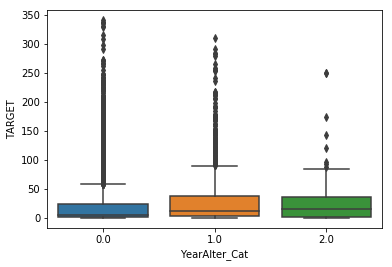

In [23]:
sns.boxplot(x = df_train_FINAL['YearAlter_Cat'], y = df_zscore_top['TARGET'])

There does not seem to be any significant pattern between TARGET and and whether a building has been altered.

#### 6d. Run HISTOGRAMS of TARGET variables and feature variables.

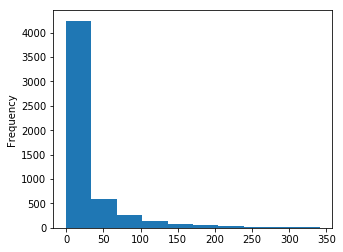

In [24]:
#%matplotlib inline
#import matplotlib as mpl
#import matplotlib.pyplot as plt

df_TARGET = df_zscore_top['TARGET']
df_TARGET.plot(kind='hist', figsize=(5, 4))
plt.show()

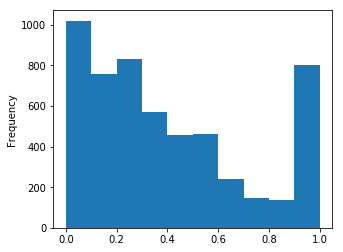

In [25]:
df_TARGET = df_zscore_top['TARGET_R']
df_TARGET.plot(kind='hist', figsize=(5, 4))
plt.show()

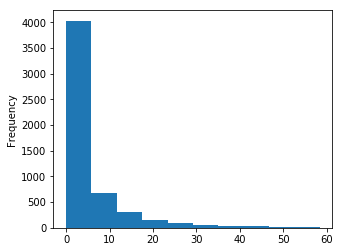

In [26]:
df_TARGET = df_zscore_top['TARGET_F']
df_TARGET.plot(kind='hist', figsize=(5, 4))
plt.show()

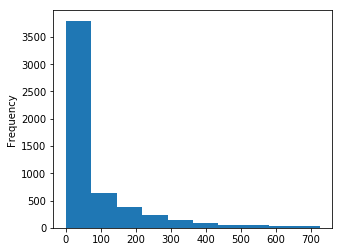

In [27]:
df_TARGET = df_zscore_top['_Tot_Complaints']
df_TARGET.plot(kind='hist', figsize=(5, 4))
plt.show()

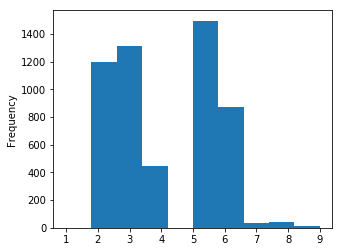

In [28]:
df_TARGET = df_zscore_top['NumFloors']
df_TARGET.plot(kind='hist', figsize=(5, 4))
plt.show()

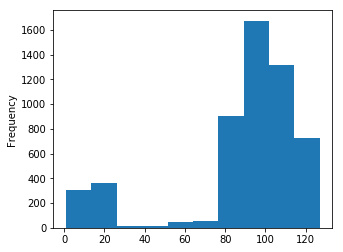

In [29]:
df_TARGET = df_zscore_top['AgeBldg']
df_TARGET.plot(kind='hist', figsize=(5, 4))
plt.show()

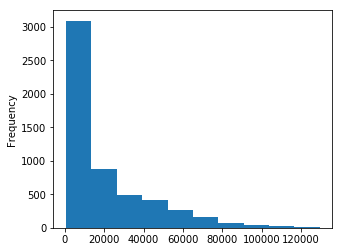

In [30]:
df_TARGET = df_zscore_top['BldgArea']
df_TARGET.plot(kind='hist', figsize=(5, 4))
plt.show()

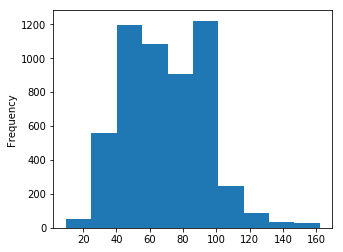

In [31]:
df_TARGET = df_zscore_top['BldgDepth']
df_TARGET.plot(kind='hist', figsize=(5, 4))
plt.show()

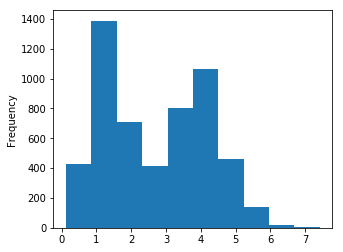

In [32]:
df_TARGET = df_zscore_top['BuiltFAR']
df_TARGET.plot(kind='hist', figsize=(5, 4))
plt.show()

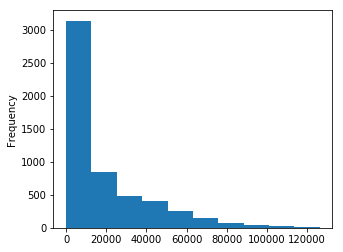

In [33]:
df_TARGET = df_zscore_top['ResArea']
df_TARGET.plot(kind='hist', figsize=(5, 4))
plt.show()

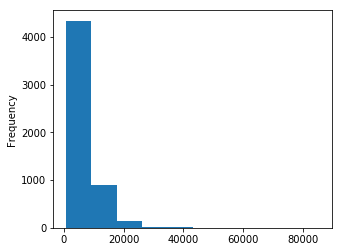

In [34]:
df_TARGET = df_zscore_top['LotArea']
df_TARGET.plot(kind='hist', figsize=(5, 4))
plt.show()

#### 6e. Run SCATTER PLOTS of TARGET variables and feature variables.

(0, 358.0918683310273)

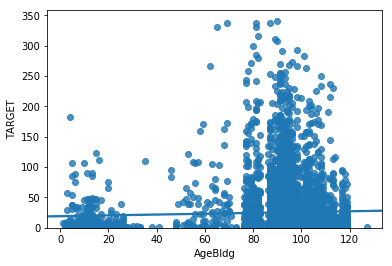

In [35]:
# Scatter Plot of 'TARGET' and 'AgeBldg'
sns.regplot(x='AgeBldg', y='TARGET', data=df_zscore_top)
plt.ylim(0,)

This plot reveals that there is indeed a relationship between BldgAge and the TARGET. Binning the feature will improve things.

(0, 358.1578626320969)

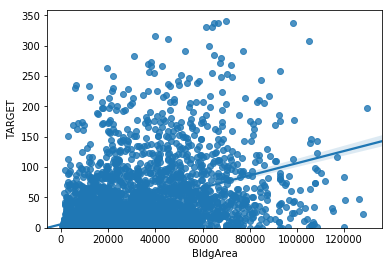

In [36]:
# Scatter Plot of 'TARGET' and 'BldgArea'
sns.regplot(x='BldgArea', y='TARGET', data=df_zscore_top)
plt.ylim(0,)

This plot reveals that there may be an important relationship between BldgArea and the TARGET. Binning the feature may improve things.

(0, 358.19003836160624)

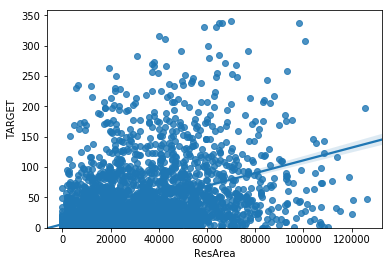

In [37]:
# Scatter Plot of 'TARGET' and 'ResArea'
sns.regplot(x='ResArea', y='TARGET', data=df_zscore_top)
plt.ylim(0,)

This plot reveals that there may be an important relationship between ResArea and the TARGET. Binning the feature may improve things.

(0, 359.2141982544673)

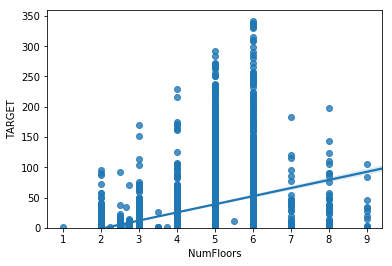

In [38]:
# Scatter Plot of 'TARGET' and 'NumFloors'
sns.regplot(x='NumFloors', y='TARGET', data=df_zscore_top)
plt.ylim(0,)

This plot reveals that there is likely an important relationship between NumFloors and the TARGET. Binning the feature will improve things.

(0, 358.8486514311389)

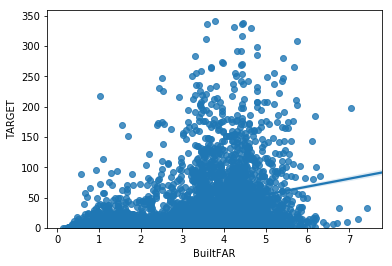

In [39]:
# Scatter Plot of 'TARGET' and 'BuiltFAR'
sns.regplot(x='BuiltFAR', y='TARGET', data=df_zscore_top)
plt.ylim(0,)

This plot reveals that there is likely an important relationship between BuiltFAR and the TARGET. Binning the feature will improve things.

(0, 359.57697651937417)

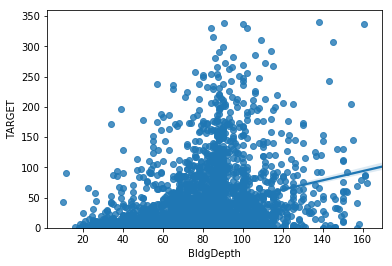

In [40]:
# Scatter Plot of 'TARGET' and 'BldgDepth'
sns.regplot(x='BldgDepth', y='TARGET', data=df_zscore_top)
plt.ylim(0,)

This plot reveals that there may be an important relationship between BldgDepth and the TARGET. Binning the feature will improve things.

(0, 371.3260913620511)

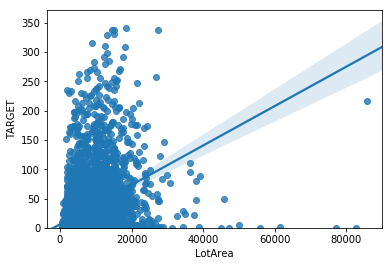

In [41]:
# Scatter Plot of 'TARGET' and 'LotArea'
sns.regplot(x='LotArea', y='TARGET', data=df_zscore_top)
plt.ylim(0,)

Outliers are an issue. This plot reveals that there may be an important relationship between LotArea and the TARGET. Binning the feature may improve things.

#### 6f. BIN 'AgeBldg', 'ResArea', 'NumFloors', 'BuiltFAR'

In [42]:
#%matplotlib inline
#import matplotlib as plt
#from matplotlib import pyplot

bin_labels_A4 = ['1-Low', '2-Med', '3-High']
df_zscore_top['AgeBldg_Bin3'] = pd.qcut(df_zscore_top['AgeBldg'],
                              q=[0, .33, .67, 1],
                              labels=bin_labels_A4)

bin_labels_B4 = ['1-Low', '2-Med', '3-High']
df_zscore_top['ResArea_Bin3'] = pd.qcut(df_zscore_top['ResArea'],
                              q=[0, .33, .67, 1],
                              labels=bin_labels_B4)

bin_labels_C4 = ['1-Low', '2-Med', '3-High']
df_zscore_top['NumFloors_Bin3'] = pd.qcut(df_zscore_top['NumFloors'],
                              q=[0, .33, .67, 1],
                              labels=bin_labels_C4)

bin_labels_D4 = ['1-Low', '2-Med', '3-High']
df_zscore_top['BuiltFAR_Bin3'] = pd.qcut(df_zscore_top['BuiltFAR'],
                              q=[0, .33, .67, 1],
                              labels=bin_labels_D4)

#df_zscore_top.head(20)
#df_zscore_top.info()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

#### 6g. CROSSTAB BINNED Features by TARGET.

In [43]:
# CROSSTAB 'AgeBldg_Bin3' by TARGET
df_zscore_top_xtab1 = df_zscore_top[['AgeBldg_Bin3', 'TARGET']]
df_zscore_top_xtab1_out = df_zscore_top_xtab1.groupby(['AgeBldg_Bin3'], as_index=False).mean()
df_zscore_top_xtab1_out

,AgeBldg_Bin3,TARGET
0,1-Low,24.341834
1,2-Med,37.180077
2,3-High,13.243582


Looking at the 'AgeBldg_Bin3' bin by the TARGET shows a clear relationship.

In [44]:
# CROSSTAB 'ResArea_Bin3' by TARGET
df_zscore_top_xtab2 = df_zscore_top[['ResArea_Bin3', 'TARGET']]
df_zscore_top_xtab2_out = df_zscore_top_xtab2.groupby(['ResArea_Bin3'], as_index=False).mean()
df_zscore_top_xtab2_out

,ResArea_Bin3,TARGET
0,1-Low,4.195422
1,2-Med,16.298160
2,3-High,55.141816


Looking at the 'ResArea_Bin3' bin by the TARGET also shows a clear relationship.

In [45]:
# CROSSTAB 'NumFloors_Bin3' by TARGET
df_zscore_top_xtab3 = df_zscore_top[['NumFloors_Bin3', 'TARGET']]
df_zscore_top_xtab3_out = df_zscore_top_xtab3.groupby(['NumFloors_Bin3'], as_index=False).mean()
df_zscore_top_xtab3_out

,NumFloors_Bin3,TARGET
0,1-Low,4.583930
1,2-Med,35.528021
2,3-High,57.448133


Looking at the 'NumFloors_Bin3' bin by the TARGET also shows a clear relationship.

In [46]:
# CROSSTAB 'BuiltFAR_Bin3' by TARGET
df_zscore_top_xtab4 = df_zscore_top[['BuiltFAR_Bin3', 'TARGET']]
df_zscore_top_xtab4_out = df_zscore_top_xtab4.groupby(['BuiltFAR_Bin3'], as_index=False).mean()
df_zscore_top_xtab4_out

,BuiltFAR_Bin3,TARGET
0,1-Low,4.383343
1,2-Med,23.137212
2,3-High,48.044183


Looking at the 'BuiltFAR_Bin3' bin by the TARGET also shows a clear relationship.

## 7. CONCLUDING REMARKS (Q3):

Q3. Does Complaint Type identified in Q1 have a useful relationship with any particular PLUTO characteristic(s) of the houses/buildings?

ANSWER: 
- YES. The features 'BldgAge', 'ResArea', 'NumFloors', and 'BuiltFAR', all have clear relationships with the TOP COMPLAINT identfied in Q1 (i.e., the 'TARGET' variable).

RESULTS/ANALYSIS SUMMARY: 
1. Analysis of Initial Correlation Results:
    - The following features were moderately correlated with the 'TARGET' variable.
        - NumFloors (.46)
        - BldgArea (.51)
        - BldDepth (.41)
        - BuiltFAR (.44)
        - LotArea (.42)
        - ResArea (.52)
    - It was interesting that the other potential target variables (i.e., TARGET_R, TARGET_F) did not correlate with much.
    - It was also surprising that the initial correlation of 'BldgAge' was not strong.
    - There was no apparent realationship between the TARGET and whether a building has been altered.
    - Note: Investigation of the PLUTO data dictionary showed that 'BuiltFAR' is calculated from 'LotArea' and 'BldgArea'.
    - These initial correlations were a little underwhelming so further exploration and visualization was conducted (see 2. below).
    
2. Scatter Plots were much more revealing than the intial correlation stats and visually identified important relationships between the TARGET vairable and the following features. These plots also revealed why the initial correlations were only moderate which suggested using a BINNING approach to tease out the correlation strenths.
    - BldgAge, BldgArea, ResArea, NumFloors, BuiltFAR, BldgDepth

3. Finally, the BINS of the top features showed strong relationships.

Stakeholder Questions (To optimize Q4 modeling, the following should be discussed with DHPD stakeholders):
1. Do the features identified to have a relationship with the TARGET varaible that makes sense to them?
2. Are there any other hypotheses they have regarding other fields in the PLUTO dataset that we may have overlooked?
  
Other Considerations:
1. Feature Engineering of the top fields identified here and the other fields may prove even more productive as we move into the modeling process.

## END OF NOTEBOOK (3 of 4)